In [1]:
import os
import torch
import numpy as np

import scanpy as sc
from anndata import AnnData

result_dir = "../edges/"
raw_type=False
use_edge=False

In [2]:
sample='Lung6'

data_dir = "../../data/NSCLC/processed1/"

ligands_info = torch.load("/".join(data_dir.split("/")[:-2]) + "/ligands.pth")
genes = torch.load("/".join(data_dir.split("/")[:-2]) + "/genes.pth")

samples=['Lung13', 'Lung6', 'Lung5_Rep1', 'Lung5_Rep3', 'Lung5_Rep2', 'Lung9_Rep1', 'Lung9_Rep2', 'Lung12']

#cell_types=['lymphocyte', 'fibroblast', 'Mcell', 'epithelial', 'tumors', 'endothelial', 'mast', 'neutrophil']
cell_types=['B-cell', 'NK', 'T CD4 memory', 'T CD4 naive', 'T CD8 memory', 'T CD8 naive', 'Treg', 'endothelial', 'epithelial', 'fibroblast', 'mDC', 'macrophage', 'mast', 'monocyte', 'neutrophil', 'pDC', 'plasmablast', 'tumor 12', 'tumor 13', 'tumor 5', 'tumor 6', 'tumor 9']

cell_type_pair_sequence=[]
for cell_typei in cell_types:
    for cell_typej in cell_types:
        cell_type_pair_sequence.append(cell_typei+"->"+cell_typej)

feature_names=[]
for i in range(len(cell_types)):
    for j in range(len(genes)):
        feature_names.append(cell_types[i]+"--"+genes[j])

In [3]:
dicts = {}
dicts['T CD8 memory'] = 'lymphocyte'
dicts['T CD8 naive'] = 'lymphocyte'
dicts['T CD4 naive'] = 'lymphocyte'
dicts['T CD4 memory'] = 'lymphocyte'
dicts['Treg'] = 'lymphocyte'
dicts['B-cell'] = 'lymphocyte'
dicts['plasmablast'] = 'lymphocyte'
dicts['NK'] = 'lymphocyte'
dicts['monocyte'] = 'Mcell' # Mcell is myeloid cell
dicts['macrophage'] = 'Mcell' 
dicts['mDC'] = 'Mcell'
dicts['pDC'] = 'Mcell'
# sigra did not have correct operations on tumors X types
dicts['tumor 9'] = 'tumors'
dicts['tumor 5'] = 'tumors'
dicts['tumor 6'] = 'tumors'
dicts['tumor 12'] = 'tumors'
dicts['tumor 13'] = 'tumors'
dicts['epithelial'] = 'epithelial'
dicts['mast'] = 'mast'
dicts['endothelial'] = 'endothelial'
dicts['fibroblast'] = 'fibroblast'
dicts['neutrophil'] = 'neutrophil'

In [6]:
def aggregate_interation_strength(sample,select_hvg=False,normalize=True):
    results=torch.load(result_dir+"edges_"+sample+".pth",map_location=torch.device('cpu'))

    position_x=results["position_x"][:,0]
    position_y=results["position_y"][:,0]
    cell_type_name=np.array(results["cell_type_name"])
    cell_type_target=cell_type_name[:,0]

    type_exp_dict=np.load(data_dir + sample + "_TypeExp.npz", allow_pickle=True)
    type_exps=torch.stack([torch.Tensor(type_exp_dict[cell_type_targeti]) for cell_type_targeti in cell_type_target],dim=0)
    results["y"]=results["y"]+type_exps
    
    attention_scores=results["attention_score"]
    cell_type_names = np.array(results["cell_type_name"])

    proportion=torch.abs(attention_scores)
    proportion=proportion/torch.sum(proportion,dim=1,keepdim=True)
    attention_scores[proportion<0.1]=0
    
    # Initialize a tensor to hold aggregated interaction strengths
    B, _, C = attention_scores.shape
    t = len(cell_types)
    aggregated_interactions = torch.zeros((B, t, C))
    
    # Map cell type names to indices
    cell_type_to_index = {ct: idx for idx, ct in enumerate(cell_types)}
    
    # Aggregate interaction strengths by cell type
    for b in range(B):
        for n in range(1, 50):  # Skip the first element, which is the target cell type
            neighbor_type = cell_type_names[b][n]
            if neighbor_type in cell_type_to_index:
                idx = cell_type_to_index[neighbor_type]
                aggregated_interactions[b, idx] += attention_scores[b, n-1]
    
    if normalize:
        aggregated_interactions1=aggregated_interactions/torch.sum(torch.abs(aggregated_interactions),dim=1,keepdim=True)
        aggregated_interactions=torch.where(torch.sum(torch.abs(aggregated_interactions),dim=1,keepdim=True)==0,torch.zeros_like(aggregated_interactions),aggregated_interactions1)
    
    #aggregated_interactions[torch.abs(aggregated_interactions)<0.025]=0
    generalized_ct=[]
    for cell_typei in cell_type_target:
        generalized_ct.append(dicts[cell_typei])

    adata = AnnData(aggregated_interactions.reshape(B,-1).numpy())
    adata.obs['cell_type'] = cell_type_target
    adata.obs['generalized_cell_type'] = generalized_ct
    adata.obs['position_x']=position_x
    adata.obs['position_y']=position_y
    adata.var_names=feature_names
    adata.obsm["y"]=results["y"].numpy()

    # Quality control
    #sc.pp.filter_cells(adata, min_genes=200)
    #sc.pp.filter_genes(adata, min_cells=3)
    if select_hvg:
        # Quality control
        sc.pp.filter_cells(adata, min_genes=200)
        sc.pp.filter_genes(adata, min_cells=3)
        # Identify highly variable genes
        sc.pp.highly_variable_genes(adata, min_mean=0, max_mean=1, min_disp=0,n_top_genes=2000)
        adata = adata[:, adata.var.highly_variable]
    print(adata.shape)
    return adata

adata=aggregate_interation_strength(sample)
print(adata)

(89091, 21120)
AnnData object with n_obs × n_vars = 89091 × 21120
    obs: 'cell_type', 'generalized_cell_type', 'position_x', 'position_y'
    obsm: 'y'


In [13]:
def plot_cell_type(adata,n_neighbors=15,color='cell_type'):
    sc.tl.pca(adata, n_comps=50)
    sc.pp.neighbors(adata,n_neighbors=n_neighbors)  # Compute the neighborhood graph
    # Plot UMAP
    sc.tl.umap(adata)  # Compute UMAP
    sc.pl.umap(adata, color=color)

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


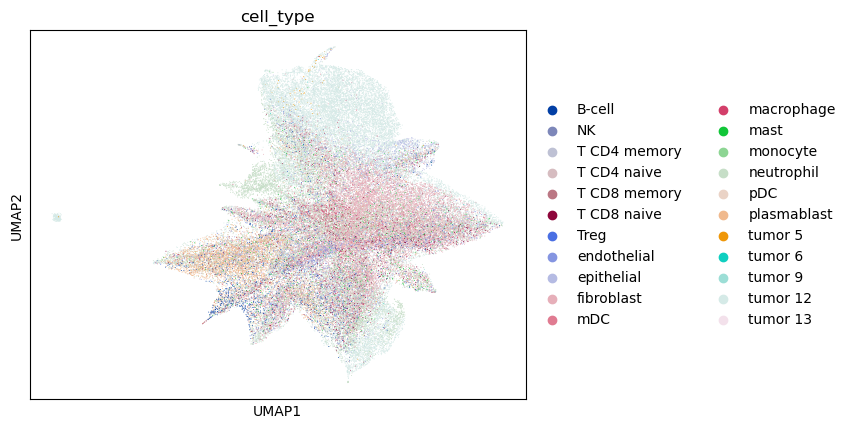

In [15]:
plot_cell_type(adata)

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


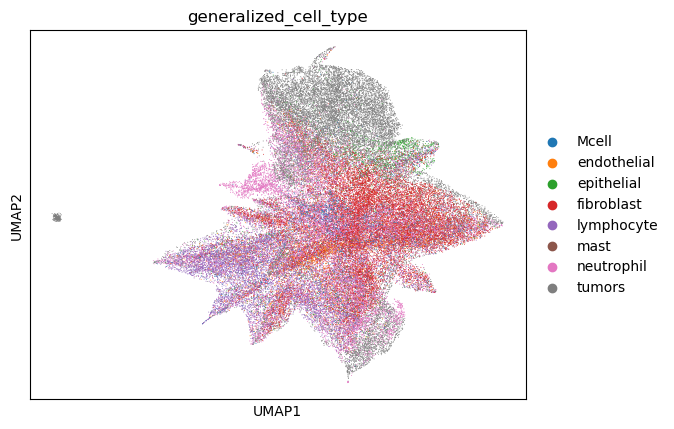

In [14]:
plot_cell_type(adata,color='generalized_cell_type')

In [8]:
adata.write('aggregated/'+sample+'.h5ad')

In [6]:
import anndata as ad
adata_y=ad.AnnData(X=np.abs(adata.obsm["y"]), obs=adata.obs)
plot_cell_type(adata_y)

NameError: name 'ad' is not defined

In [ ]:
samples=['Lung6', 'Lung5_Rep1', 'Lung5_Rep3', 'Lung5_Rep2', 'Lung9_Rep1', 'Lung9_Rep2', 'Lung12','Lung13']
adata_list=[]
for samplei in samples:
    adata=aggregate_interation_strength(samplei)
    adata_list.append(adata)
    adata.write('aggregated/'+samplei+'.h5ad')
    
    plot_cell_type(adata,color='generalized_cell_type')
    plot_cell_type(adata)
    
    adata_y=ad.AnnData(X=np.abs(adata.obsm["y"]), obs=adata.obs)
    plot_cell_type(adata_y,color='generalized_cell_type')
    plot_cell_type(adata_y)

merged_adata = sc.concat(adata_list, label="batch")
merged_adata.write('all_aggregated.h5ad')

In [ ]:
plot_cell_type(merged_adata,color="batch")

In [ ]:
plot_cell_type(merged_adata)

In [ ]:
plot_cell_type(merged_adata,color='generalized_cell_type')